In [1]:
%%capture
! pip install catboost
! pip install optuna
! pip install optuna-dashboard

In [2]:
# Data structure
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data preperation
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold, cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer
import optuna
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report, confusion_matrix

# Models
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif

# Metrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix,classification_report
from sklearn.utils.class_weight import compute_class_weight

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Spliting the data

In [3]:
# Read Data From csv file
df = pd.read_csv('cirrhosis_preprocessed.csv')

# Define the features and the target
X = df.drop(columns=['Stage'], axis=1)
y = df['Stage']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [4]:
print(f"{X.head(10)}")
print(f"{y.head(10)}")

   N_Days  Sex  Ascites  Hepatomegaly  Spiders  Bilirubin  Cholesterol  \
0     400    0        1             1        1       14.5        261.0   
1    4500    0        0             1        1        1.1        302.0   
2    1012    1        0             0        0        1.4        176.0   
3    1925    0        0             1        1        1.8        244.0   
4    1504    0        0             1        1        3.4        279.0   
5    2503    0        0             1        0        0.8        248.0   
6    1832    0        0             1        0        1.0        322.0   
7    2466    0        0             0        0        0.3        280.0   
8    2400    0        0             0        1        3.2        562.0   
9      51    0        1             0        1       12.6        200.0   

   Copper  Alk_Phos    SGOT  Tryglicerides  Platelets  Status_CL  Status_D  \
0   156.0    1718.0  137.95          172.0      190.0          0         1   
1    54.0    7394.8  113.52  

# Scailing

In [5]:
from sklearn.preprocessing import MinMaxScaler as MM_Scaler

# Standardize Scaler
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

# Min Max Scaler
scaler_minmax = MM_Scaler()
X_train_minmax = pd.DataFrame(scaler_minmax.fit_transform(X_train), columns=X.columns)
X_test_minmax = pd.DataFrame(scaler_minmax.transform(X_test), columns=X.columns)

# Evaluations

We will evaluate our models using key quality metrics to identify the best-performing one on the test set. This includes confusion matrix analysis for classification effectiveness and evalution metrics like F1-score, precision, and recall to assess performance across classes.

**Evalution Matrix**

In the given multiclass classification task with labels 1, 2, and 3. We design the confusion matrix to highlight misclassifications by coloring off-diagonal values red, while emphasizing correct classifications by bolding the diagonal values.








In [6]:
def print_confusion_matrix(y_test, y_pred, classifier):
    # Plot the confusion matrix as a heatmap
    labels=[1, 2, 3]
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    plt.figure(figsize=(6, 4))
    ax = sns.heatmap(cm, annot=False, fmt='d', cmap='Purples', cbar=False,
                xticklabels=labels, yticklabels=labels)

    # Annotate the heatmap with bold diagonal values
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if i == j:  # Bold diagonal values
                ax.text(j + 0.5, i + 0.5, f"{cm[i, j]}",
                        ha='center', va='center', color='white', fontweight='bold',
                        fontsize=16)
            else:  # Regular font for off-diagonal values
                ax.text(j + 0.5, i + 0.5, f"{cm[i, j]}",
                        ha='center', va='center', color='red',
                        fontsize=16)

    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix for {classifier} Classifier')
    plt.show()

***Evaluation Metrics***

For eacm model, we use several metrics to evaluates its preformences given the confuction matrix values:


*   Accuracy - Reflects the proportion of correct predictions.
*   Precision - The proportion of correct predictions for a class out of all instances predicted as that class.
*   Recall -  The proportion of correct predictions for a class out of all actual instances of that class.
*   F1 score - The harmonic mean of precision and recall, providing a single metric to balance both.

**Macro Average** - The arithmetic mean of metrics calculated per class, treating all classes equally.

**Weighted Average** - A weighted mean of metrics, considering the number of true samples (support) for each class.

**Support** value in the report represent the number of instances for each class in the test set.









**Statistical Analysis of Model Replication**

**Experimental Design**
We conduct multiple independent trials to assess model performance stability. Each trial maintains independence through unique random seeds, allowing us to quantify the variance in model performance introduced by initialization and sampling effects.

**Statistical Analysis**
Performance variability is quantified using Student's t-distribution for confidence intervals, appropriate for our small sample scenario. We analyze the spread of F1-score, accuracy, precision, and recall across trials, capturing both the central tendency and variance of model performance. The resulting 95% confidence intervals provide robust bounds on expected real-world performance, accounting for both initialization and sampling uncertainty.

In [48]:
def run_model_replications( ml_model, X_train, X_test, y_train, y_test, best_params, n_replications=10):
    """
    Run model multiple times and calculate statistics.

    Parameters:
    -----------
    X_train, X_test : array-like
        Training and test features
    y_train, y_test : array-like
        Training and test labels
    best_params : dict
        Best parameters from Optuna optimization
    n_replications : int
        Number of times to repeat the experiment

    Returns:
    --------
    dict
        Dictionary containing means and confidence intervals for each metric
    """
    # Initialize arrays to store metrics
    f1_scores = np.zeros(n_replications)
    accuracy_scores = np.zeros(n_replications)
    precision_scores = np.zeros(n_replications)
    recall_scores = np.zeros(n_replications)

    # Run the model n_replications times
    for i in range(n_replications):
        # Create and train model with best parameters
        model = ml_model(
            eval_metric='TotalF1',
            verbose=0,
            random_seed= 42 + i,  # Different seed for each replication
            **best_params
        )

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Calculate metrics
        f1_scores[i] = f1_score(y_test, y_pred, average='macro')
        accuracy_scores[i] = accuracy_score(y_test, y_pred)
        precision_scores[i] = precision_score(y_test, y_pred, average='macro')
        recall_scores[i] = recall_score(y_test, y_pred, average='macro')

    # Calculate statistics for each metric
    def calculate_stats(metric_scores):
        mean = np.mean(metric_scores)
        ci = stats.t.interval(
            confidence=0.95,
            df=len(metric_scores)-1,
            loc=np.mean(metric_scores),
            scale=stats.sem(metric_scores)
        )
        return {
            'mean': mean,
            'ci_lower': ci[0],
            'ci_upper': ci[1],
            'std': np.std(metric_scores),
            'raw_scores': metric_scores
        }

    results = {
        'f1_score': calculate_stats(f1_scores),
        'accuracy': calculate_stats(accuracy_scores),
        'precision': calculate_stats(precision_scores),
        'recall': calculate_stats(recall_scores)
    }

    return results

def replications_print(results, n_replications):
  # Print results in a formatted way
   print("\nResults over", n_replications, "replications:\n")
   for metric, stats in results.items():
     print(f"{metric.upper()}:")
     print(f"Mean: {stats['mean']:.4f}")
     print(f"95% CI: [{stats['ci_lower']:.4f}, {stats['ci_upper']:.4f}]")
     print(f"Standard Deviation: {stats['std']:.4f}")


# Random Forest - 0.72 weighted f1

Default Model


Random Forest default hyperparameters:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


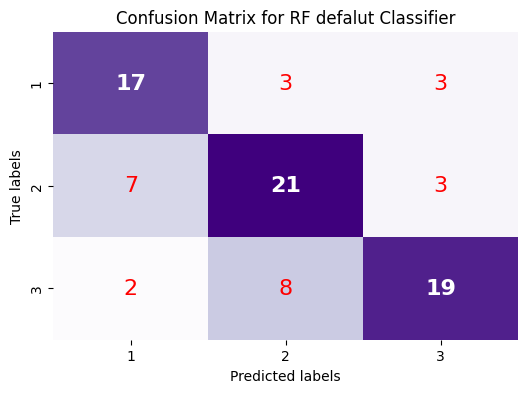

RF default Classifier Report:
               precision    recall  f1-score   support

         1.0      0.654     0.739     0.694        23
         2.0      0.656     0.677     0.667        31
         3.0      0.760     0.655     0.704        29

    accuracy                          0.687        83
   macro avg      0.690     0.691     0.688        83
weighted avg      0.692     0.687     0.687        83



In [8]:
#---Default model----
RF_model_def = RandomForestClassifier(random_state=42)
RF_model_def.fit(X_train, y_train)

# Random Forest default hyperparameters
print("\nRandom Forest default hyperparameters:")
print(RF_model_def.get_params())

y_pred_RF_def = RF_model_def.predict(X_test)

# Evaluation
print_confusion_matrix(y_test, y_pred_RF_def, "RF defalut")

print("RF default Classifier Report:\n", classification_report(y_test, y_pred_RF_def, digits=3))

Tuning RF model - GridSearch

In [ ]:
# Create a random forest classifier
rf = RandomForestClassifier(random_state=42)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],  # Number of trees in the forest
    'max_depth': [None, 2, 5, 10],  # Maximum depth of the tree
    'max_features': ['sqrt', 'log2', None],  # Number of features to consider when looking for the best split
    'criterion': ['gini', 'entropy'],  # Function to measure the quality of a split
    'min_samples_split': [2, 5, 10, 20]
}

# Instantiate the grid search with cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='f1_macro', verbose=1)
# Perform the grid search
grid_search.fit(X_train, y_train)
print("Best parameters found: ", grid_search.best_params_)
best_rf = grid_search.best_estimator_
print(best_rf)

Fitting 3 folds for each of 480 candidates, totalling 1440 fits
Best parameters found:  {'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 400}
RandomForestClassifier(criterion='entropy', min_samples_split=10,
                       n_estimators=400, random_state=42)


Random Forest - GridSearch Tuned

              precision    recall  f1-score   support

         1.0       0.68      0.74      0.71        23
         2.0       0.74      0.65      0.69        31
         3.0       0.74      0.79      0.77        29

    accuracy                           0.72        83
   macro avg       0.72      0.73      0.72        83
weighted avg       0.72      0.72      0.72        83



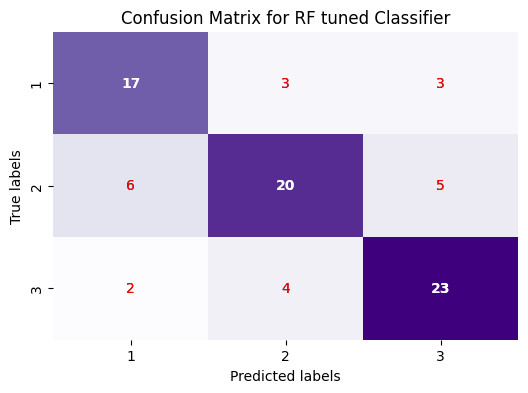

In [ ]:
# Tuned RF Model
rf_model_grid = RandomForestClassifier(max_depth=2,
                                    max_features="sqrt",
                                    n_estimators=500,
                                    criterion='gini',
                                    min_samples_split=2, random_state=42)
rf_model_grid.fit(X_train, y_train)

rf_model_grid = RandomForestClassifier(max_depth=None,
                                    max_features="sqrt",
                                    n_estimators=400,
                                    criterion='entropy',
                                    min_samples_split=10, random_state=42)
rf_model_grid.fit(X_train, y_train)

# Prediction and evaluation
y_pred_grid = rf_model_grid.predict(X_test)
print(classification_report(y_test, y_pred_grid))
print_confusion_matrix(y_test, y_pred_grid, "RF tuned")

Tuning RF model - optuna

In [ ]:
def objective(trial):
    """
    This is the function that Optuna optimizes.
     It takes a trial object as input, tests a specific set of hyperparameters, and returns a performance score
    :param trial: trial object is a specific set of hyperparameters
    :return: performance score (here it is f1)
    """
    # Hyperparameter search space
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 1, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])

    # Model initialization
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        max_features=max_features,
        criterion=criterion,
        random_state=42
    )

    # Cross-validation
    kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    f1_scores = cross_val_score(clf, X_train, y_train, cv=kfold, scoring="f1_macro")
    return f1_scores.mean()


# Optimization task to maximize score
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print("Best hyperparameters with optuna optimization:", study.best_params)
rf_optuna = RandomForestClassifier(**study.best_params, random_state=42)
rf_optuna.fit(X_train, y_train)

[I 2025-02-24 14:43:15,886] A new study created in memory with name: no-name-a0a6d387-9d7d-4c62-9785-79e5db27b494
[I 2025-02-24 14:43:16,670] Trial 0 finished with value: 0.6718101850146737 and parameters: {'n_estimators': 175, 'max_depth': 29, 'min_samples_split': 9, 'max_features': 'log2', 'criterion': 'gini'}. Best is trial 0 with value: 0.6718101850146737.
[I 2025-02-24 14:43:18,718] Trial 1 finished with value: 0.6655435249998064 and parameters: {'n_estimators': 483, 'max_depth': 48, 'min_samples_split': 17, 'max_features': 'log2', 'criterion': 'gini'}. Best is trial 0 with value: 0.6718101850146737.
[I 2025-02-24 14:43:20,253] Trial 2 finished with value: 0.6834625497750496 and parameters: {'n_estimators': 354, 'max_depth': 16, 'min_samples_split': 12, 'max_features': 'sqrt', 'criterion': 'gini'}. Best is trial 2 with value: 0.6834625497750496.
[I 2025-02-24 14:43:22,165] Trial 3 finished with value: 0.6747062400075888 and parameters: {'n_estimators': 450, 'max_depth': 36, 'min_s

Best hyperparameters with optuna optimization: {'n_estimators': 464, 'max_depth': 31, 'min_samples_split': 10, 'max_features': 'sqrt', 'criterion': 'gini'}


RandomForestClassifier(max_depth=31, min_samples_split=10, n_estimators=464,
                       random_state=42)

In [ ]:
# Get the best parameters
best_params = study.best_params
print("Best Parameters:", best_params)

Best Parameters: {'n_estimators': 464, 'max_depth': 31, 'min_samples_split': 10, 'max_features': 'sqrt', 'criterion': 'gini'}


RF tuned Classifier Report:
               precision    recall  f1-score   support

         1.0      0.680     0.739     0.708        23
         2.0      0.741     0.645     0.690        31
         3.0      0.742     0.793     0.767        29

    accuracy                          0.723        83
   macro avg      0.721     0.726     0.722        83
weighted avg      0.724     0.723     0.722        83



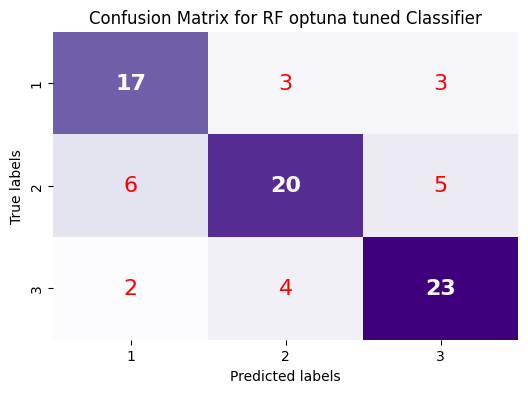

In [10]:
rf_model_optuna = RandomForestClassifier(max_depth=31,
                                         max_features="log2",
                                         n_estimators=464,
                                         criterion='entropy',
                                         min_samples_split=10, random_state=42)
rf_model_optuna.fit(X_train, y_train)

# Prediction and evaluation
y_pred_optuna = rf_model_optuna.predict(X_test)
print("RF tuned Classifier Report:\n", classification_report(y_test, y_pred_optuna, digits=3))
print_confusion_matrix(y_test, y_pred_optuna, "RF optuna tuned")

In [ ]:
# Plot optimization history
optuna.visualization.plot_optimization_history(study).show()

# Plot parameter importance
optuna.visualization.plot_param_importances(study).show()

**Feature imortance**

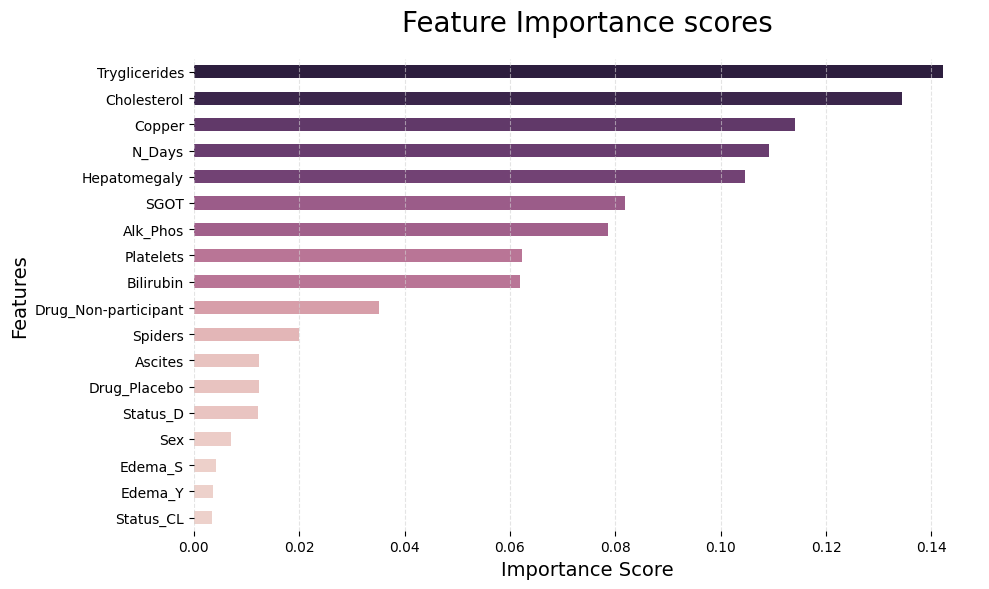

In [ ]:
importance = rf_model_optuna.feature_importances_
feature_scores = pd.Series(importance, index=X_train.columns).sort_values(ascending=False)

# Create a colormap
cmap = sns.cubehelix_palette(as_cmap=True, reverse=False)

# Create color array based on values
norm = mcolors.Normalize(vmin=feature_scores.min(), vmax=feature_scores.max())
colors = [cmap(norm(value)) for value in feature_scores]

plt.figure(figsize=(10, 6))
ax = feature_scores.plot(kind='barh', color=colors)
plt.title("Feature Importance scores", fontsize=20, pad=20)
plt.xlabel("Importance Score", fontsize=14)
plt.ylabel("Features", fontsize=14)
plt.gca().invert_yaxis()

# Add grid
plt.grid(axis='x', linestyle='--', alpha=0.6, color='#d3d3d3')

# Remove spines
for spine in ax.spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.show()

**CI**

In [11]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from scipy.stats import t, sem
import numpy as np

def run_model_replications(model, X_train, X_test, y_train, y_test, n_replications=10):
    """
    Run model multiple times and calculate statistics.

    Parameters:
    -----------
    model : sklearn model object
        A pre-configured machine learning model.
    X_train, X_test : array-like
        Training and test features.
    y_train, y_test : array-like
        Training and test labels.
    n_replications : int
        Number of times to repeat the experiment.

    Returns:
    --------
    dict
        Dictionary containing means and confidence intervals for each metric.
    """
    # Initialize arrays to store metrics
    f1_scores = np.zeros(n_replications)
    accuracy_scores = np.zeros(n_replications)
    precision_scores = np.zeros(n_replications)
    recall_scores = np.zeros(n_replications)

    # Run the model n_replications times
    for i in range(n_replications):
        # Set a different random state for each replication
        model.random_state = 42 + i

        # Train and test the model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Calculate metrics
        f1_scores[i] = f1_score(y_test, y_pred, average='macro')
        accuracy_scores[i] = accuracy_score(y_test, y_pred)
        precision_scores[i] = precision_score(y_test, y_pred, average='macro')
        recall_scores[i] = recall_score(y_test, y_pred, average='macro')

    # Calculate statistics for each metric
    def calculate_stats(metric_scores):
        mean = np.mean(metric_scores)
        ci = t.interval(
            confidence=0.95,
            df=len(metric_scores) - 1,
            loc=mean,
            scale=sem(metric_scores)
        )
        return {
            'mean': mean,
            'ci_lower': ci[0],
            'ci_upper': ci[1],
            'std': np.std(metric_scores),
            'raw_scores': metric_scores
        }

    results = {
        'f1_score': calculate_stats(f1_scores),
        'accuracy': calculate_stats(accuracy_scores),
        'precision': calculate_stats(precision_scores),
        'recall': calculate_stats(recall_scores)
    }

    return results

# Instantiate the model with your predefined parameters
rf_model_optuna = RandomForestClassifier(max_depth=31,
                                         max_features="log2",
                                         n_estimators=464,
                                         criterion='entropy',
                                         min_samples_split=10,
                                         random_state=42)

# Run replications
n_replications = 10
results = run_model_replications(rf_model_optuna, X_train, X_test, y_train, y_test, n_replications)

# Print results in a formatted way
print("\nResults over", n_replications, "replications:\n")
for metric, stats in results.items():
    print(f"{metric.upper()}:")
    print(f"Mean: {stats['mean']:.4f}")
    print(f"95% CI: [{stats['ci_lower']:.4f}, {stats['ci_upper']:.4f}]")
    print(f"Standard Deviation: {stats['std']:.4f}")


Results over 10 replications:

F1_SCORE:
Mean: 0.7128
95% CI: [0.7027, 0.7229]
Standard Deviation: 0.0134
ACCURACY:
Mean: 0.7133
95% CI: [0.7027, 0.7238]
Standard Deviation: 0.0141
PRECISION:
Mean: 0.7121
95% CI: [0.7020, 0.7223]
Standard Deviation: 0.0134
RECALL:
Mean: 0.7166
95% CI: [0.7069, 0.7263]
Standard Deviation: 0.0128


# XGBoost

In [12]:
# Import libraries
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [13]:
# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

**DEFAULT MODEL**

In [14]:
# Ensure labels are mapped correctly to 0-based format
y_train_min = y_train.min()
y_test_min = y_test.min()

# Check the minimum value and adjust accordingly
if y_train_min < 0 or y_test_min < 0:
    raise ValueError("y_train or y_test contains negative labels, which are invalid.")

# Map labels to 0-based if they are not already
y_train_0_based = (y_train - y_train_min).astype(int)
y_test_0_based = (y_test - y_test_min).astype(int)

Default XGBoost Classifier Report:
               precision    recall  f1-score   support

           1       0.62      0.65      0.64        23
           2       0.62      0.65      0.63        31
           3       0.74      0.69      0.71        29

    accuracy                           0.66        83
   macro avg       0.66      0.66      0.66        83
weighted avg       0.67      0.66      0.66        83



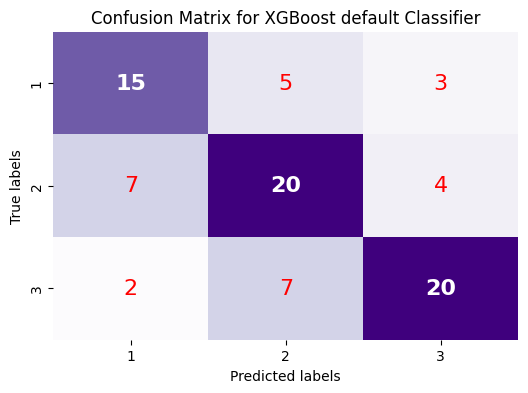

In [16]:
# Adjust target labels to start from 0 for training
y_train_0_based = (y_train - 1).astype(int)
y_test_0_based = (y_test - 1).astype(int)

# Initialize the XGBoost Default model
xgb_model_default = xgb.XGBClassifier(random_state=42)

# Train the default XGBoost model
xgb_model_default.fit(X_train, y_train_0_based)

# Predict and evaluate the default model
y_pred_default = xgb_model_default.predict(X_test) + 1  # Map back to 1-based
y_test_1_based = y_test_0_based + 1
print("Default XGBoost Classifier Report:\n", classification_report(y_test_1_based, y_pred_default))
print_confusion_matrix(y_test_1_based, y_pred_default, "XGBoost default")
# custom_evaluation(y_test_1_based, y_pred_default, "Default XGBoost Model")

In [ ]:
# Wrap the classifier in a pipeline
pipeline = Pipeline([
    ('classifier', xgb.XGBClassifier(random_state=42, eval_metric='mlogloss'))
])

**GRID SEARCH**

In [ ]:
# Define expanded parameter grid for Grid Search
param_grid = {
    'classifier__n_estimators': [50, 100, 200, 300],
    'classifier__max_depth': [3, 4, 5, 6, 8, 10],
    'classifier__learning_rate': [0.001, 0.01, 0.1, 0.2],
    'classifier__subsample': [0.5, 0.6, 0.8, 1.0],
    'classifier__colsample_bytree': [0.5, 0.6, 0.8, 1.0]
}

# Initialize Grid Search
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=3,
    verbose=2
)

# Fit the Grid Search
grid_search.fit(X_train, y_train_0_based)

# Print best parameters
print("Best parameters:", grid_search.best_params_)

Fitting 3 folds for each of 1536 candidates, totalling 4608 fits
[CV] END classifier__colsample_bytree=0.5, classifier__learning_rate=0.001, classifier__max_depth=3, classifier__n_estimators=50, classifier__subsample=0.5; total time=   0.1s
[CV] END classifier__colsample_bytree=0.5, classifier__learning_rate=0.001, classifier__max_depth=3, classifier__n_estimators=50, classifier__subsample=0.5; total time=   0.0s
[CV] END classifier__colsample_bytree=0.5, classifier__learning_rate=0.001, classifier__max_depth=3, classifier__n_estimators=50, classifier__subsample=0.5; total time=   0.1s
[CV] END classifier__colsample_bytree=0.5, classifier__learning_rate=0.001, classifier__max_depth=3, classifier__n_estimators=50, classifier__subsample=0.6; total time=   0.1s
[CV] END classifier__colsample_bytree=0.5, classifier__learning_rate=0.001, classifier__max_depth=3, classifier__n_estimators=50, classifier__subsample=0.6; total time=   0.1s
[CV] END classifier__colsample_bytree=0.5, classifier__

**TUNED MODEL**

Tuned XGBoost Classifier Report:
               precision    recall  f1-score   support

           1      0.680     0.739     0.708        23
           2      0.690     0.645     0.667        31
           3      0.724     0.724     0.724        29

    accuracy                          0.699        83
   macro avg      0.698     0.703     0.700        83
weighted avg      0.699     0.699     0.698        83



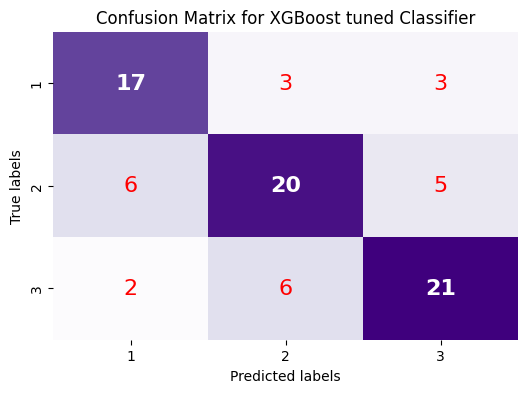

In [18]:
# Initialize the tuned XGB Model with the best parameters found

tuned_xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.001,
    subsample=0.5,
    colsample_bytree=0.5,
    eval_metric="mlogloss",
    random_state=42
)

# Train the tuned model on 0-based labels
tuned_xgb_model.fit(X_train, y_train_0_based)

# Predict on the test set and map back to 1-based labels
y_pred_tuned_0_based = tuned_xgb_model.predict(X_test)  # Predictions in 0-based format
y_pred_tuned_1_based = y_pred_tuned_0_based + 1         # Map predictions to 1-based format

# Evaluate the tuned model
# custom_evaluation(y_test_1_based, y_pred_tuned_1_based, "Tuned XGBoost Model")
print("Tuned XGBoost Classifier Report:\n", classification_report(y_test_1_based, y_pred_tuned_1_based, digits = 3))
print_confusion_matrix(y_test_1_based, y_pred_tuned_1_based, "XGBoost tuned")

**OPTUNA**

[I 2025-02-24 16:00:03,295] A new study created in memory with name: no-name-664d2d66-e5df-4e9a-9f22-12f5f0cbdbeb
[I 2025-02-24 16:00:05,960] Trial 0 finished with value: 0.6594147180592688 and parameters: {'n_estimators': 216, 'max_depth': 10, 'learning_rate': 0.005342090445168706, 'subsample': 0.6657572454118076, 'colsample_bytree': 0.7093172913014261}. Best is trial 0 with value: 0.6594147180592688.
[I 2025-02-24 16:00:06,684] Trial 1 finished with value: 0.662460230243698 and parameters: {'n_estimators': 485, 'max_depth': 3, 'learning_rate': 0.2453411986097743, 'subsample': 0.5542831171705119, 'colsample_bytree': 0.590755277765342}. Best is trial 1 with value: 0.662460230243698.
[I 2025-02-24 16:00:09,054] Trial 2 finished with value: 0.6570615791401226 and parameters: {'n_estimators': 154, 'max_depth': 13, 'learning_rate': 0.003634151501386564, 'subsample': 0.5497831018923631, 'colsample_bytree': 0.8668264432891246}. Best is trial 1 with value: 0.662460230243698.
[I 2025-02-24 16:

Best parameters: {'n_estimators': 66, 'max_depth': 10, 'learning_rate': 0.007361899931803506, 'subsample': 0.8496727956450908, 'colsample_bytree': 0.6582704187129875}
Tuned XGBoost Classifier Report:
               precision    recall  f1-score   support

         1.0       0.65      0.74      0.69        23
         2.0       0.70      0.68      0.69        31
         3.0       0.78      0.72      0.75        29

    accuracy                           0.71        83
   macro avg       0.71      0.71      0.71        83
weighted avg       0.71      0.71      0.71        83



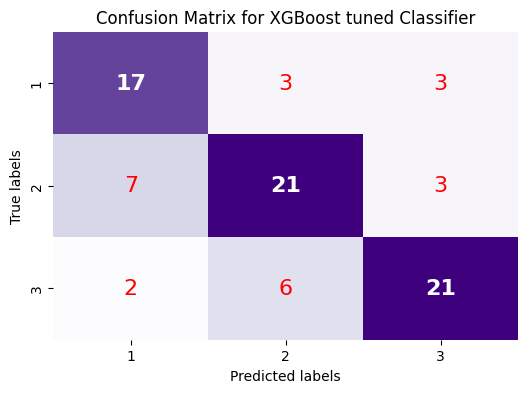

In [ ]:
from xgboost import XGBClassifier
import optuna

# Ensure labels are mapped correctly to 0-based format
y_train_min = y_train.min()
if y_train_min < 0:
    raise ValueError("y_train contains negative labels, which are invalid.")

# Map labels to 0-based format
y_train_0_based = (y_train - y_train_min).astype(int)
y_test_0_based = (y_test - y_train_min).astype(int)
y_test_1_based = y_test_0_based + y_train_min  # Map back to 1-based for evaluation

# Define the objective function for Optuna
def objective(trial):
    """
    A function to optimize hyperparameters for XGBoost using Optuna.
    """
    # Hyperparameter search space
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 2, 20)
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.3, log=True)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)

    # Model initialization
    xgb_model = XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        use_label_encoder=False,
        eval_metric="mlogloss",
        random_state=42
    )

    # Cross-validation
    kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    f1_scores = cross_val_score(xgb_model, X_train, y_train_0_based, cv=kfold, scoring='f1_macro')

    return f1_scores.mean()

# Optimization task to maximize the F1 score
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)  # Adjust n_trials as needed

# Display the best hyperparameters
print("Best parameters:", study.best_params)

# Train the best model with the optimal parameters
tuned_xgb_model = XGBClassifier(
    **study.best_params,  # Unpack the best hyperparameters
    use_label_encoder=False,
    eval_metric="mlogloss",
    random_state=42
)

# Train the model on 0-based labels
tuned_xgb_model.fit(X_train, y_train_0_based)

# Predict on the test set and map back to 1-based labels
y_pred_0_based = tuned_xgb_model.predict(X_test)  # Predictions in 0-based format
y_pred_1_based = y_pred_0_based + y_train_min  # Map predictions to 1-based format

# Evaluate the tuned model
# custom_evaluation(y_test_1_based, y_pred_1_based, "Tuned XGBoost Model (Optuna)")
print("Tuned XGBoost Classifier Report:\n", classification_report(y_test_1_based, y_pred_1_based))
print_confusion_matrix(y_test_1_based, y_pred_1_based, "XGBoost tuned")

Tuned XGBoost Classifier Report:
               precision    recall  f1-score   support

           1      0.654     0.739     0.694        23
           2      0.700     0.677     0.689        31
           3      0.778     0.724     0.750        29

    accuracy                          0.711        83
   macro avg      0.711     0.714     0.711        83
weighted avg      0.714     0.711     0.711        83



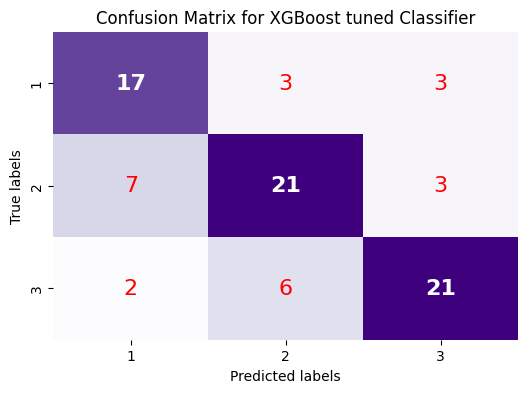

In [19]:
# Initialize the tuned XGB Model with the best parameters found

optuna_xgb_model = xgb.XGBClassifier(
    n_estimators=66,
    max_depth=10,
    learning_rate=0.007361899931803506,
    subsample=0.8496727956450908,
    colsample_bytree=0.6582704187129875,
    eval_metric="mlogloss",
    random_state=42
)

# Train the tuned model on 0-based labels
optuna_xgb_model.fit(X_train, y_train_0_based)

# Predict on the test set and map back to 1-based labels
y_pred_tuned_0_based = optuna_xgb_model.predict(X_test)  # Predictions in 0-based format
y_pred_tuned_1_based = y_pred_tuned_0_based + 1         # Map predictions to 1-based format

# Evaluate the tuned model
# custom_evaluation(y_test_1_based, y_pred_tuned_1_based, "Tuned XGBoost Model")
print("Tuned XGBoost Classifier Report:\n", classification_report(y_test_1_based, y_pred_tuned_1_based, digits = 3))
print_confusion_matrix(y_test_1_based, y_pred_tuned_1_based, "XGBoost tuned")

**CI**

In [21]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from scipy.stats import t, sem
import numpy as np
from sklearn.base import clone
from xgboost import XGBClassifier

def run_model_replications(model, X_train, X_test, y_train, y_test, n_replications=10, model_type='sklearn'):
   """
   Run model multiple times and calculate statistics.

   Parameters:
   -----------
   model : sklearn or xgboost model object
       A pre-configured machine learning model.
   X_train, X_test : array-like
       Training and test features.
   y_train, y_test : array-like
       Training and test labels.
   n_replications : int
       Number of times to repeat the experiment.
   model_type : str
       Type of model ('sklearn' or 'xgboost').

   Returns:
   --------
   dict
       Dictionary containing means and confidence intervals for each metric.
   """
   # Initialize arrays to store metrics
   f1_scores = np.zeros(n_replications)
   accuracy_scores = np.zeros(n_replications)
   precision_scores = np.zeros(n_replications)
   recall_scores = np.zeros(n_replications)

   # Run the model n_replications times
   for i in range(n_replications):
       if model_type == 'xgboost':
           # For XGBoost, create a new instance with updated random_state
           current_model = XGBClassifier(**{**model.get_params(), 'random_state': 42 + i})
       else:
           # For sklearn models that allow attribute setting
           current_model = clone(model)
           current_model.random_state = 42 + i

       # Train and test the model
       current_model.fit(X_train, y_train_0_based)
       y_pred = current_model.predict(X_test) + 1

       # Calculate metrics
       f1_scores[i] = f1_score(y_test, y_pred, average='macro')
       accuracy_scores[i] = accuracy_score(y_test, y_pred)
       precision_scores[i] = precision_score(y_test, y_pred, average='macro')
       recall_scores[i] = recall_score(y_test, y_pred, average='macro')

   # Calculate statistics for each metric
   def calculate_stats(metric_scores):
       mean = np.mean(metric_scores)
       ci = t.interval(
           confidence=0.95,
           df=len(metric_scores) - 1,
           loc=mean,
           scale=sem(metric_scores)
       )
       return {
           'mean': mean,
           'ci_lower': ci[0],
           'ci_upper': ci[1],
           'std': np.std(metric_scores),
           'raw_scores': metric_scores
       }

   results = {
       'f1_score': calculate_stats(f1_scores),
       'accuracy': calculate_stats(accuracy_scores),
       'precision': calculate_stats(precision_scores),
       'recall': calculate_stats(recall_scores)
   }

   return results

optuna_xgb_model = xgb.XGBClassifier(
    n_estimators=66,
    max_depth=10,
    learning_rate=0.007361899931803506,
    subsample=0.8496727956450908,
    colsample_bytree=0.6582704187129875,
    eval_metric="mlogloss",
    random_state=42
)

# Run replications
n_replications = 10
xgb_results = run_model_replications(optuna_xgb_model, X_train, X_test, y_train, y_test,
                                     n_replications=10, model_type='xgboost')
# Print results in a formatted way
print("\nResults over", n_replications, "replications:\n")
for metric, stats in xgb_results.items():
    print(f"{metric.upper()}:")
    print(f"Mean: {stats['mean']:.4f}")
    print(f"95% CI: [{stats['ci_lower']:.4f}, {stats['ci_upper']:.4f}]")
    print(f"Standard Deviation: {stats['std']:.4f}")


Results over 10 replications:

F1_SCORE:
Mean: 0.6991
95% CI: [0.6848, 0.7135]
Standard Deviation: 0.0190
ACCURACY:
Mean: 0.6988
95% CI: [0.6841, 0.7134]
Standard Deviation: 0.0194
PRECISION:
Mean: 0.6999
95% CI: [0.6859, 0.7140]
Standard Deviation: 0.0187
RECALL:
Mean: 0.7013
95% CI: [0.6871, 0.7155]
Standard Deviation: 0.0189


# CatBoost

Learning rate set to 0.074765
0:	learn: 1.0698189	total: 25.7ms	remaining: 25.7s
1:	learn: 1.0405114	total: 44ms	remaining: 21.9s
2:	learn: 1.0103120	total: 59.7ms	remaining: 19.8s
3:	learn: 0.9854158	total: 68ms	remaining: 16.9s
4:	learn: 0.9593868	total: 89.8ms	remaining: 17.9s
5:	learn: 0.9366946	total: 103ms	remaining: 17.1s
6:	learn: 0.9166484	total: 111ms	remaining: 15.8s
7:	learn: 0.8994870	total: 132ms	remaining: 16.3s
8:	learn: 0.8806897	total: 144ms	remaining: 15.8s
9:	learn: 0.8644997	total: 153ms	remaining: 15.2s
10:	learn: 0.8480273	total: 165ms	remaining: 14.8s
11:	learn: 0.8315503	total: 181ms	remaining: 14.9s
12:	learn: 0.8176614	total: 197ms	remaining: 14.9s
13:	learn: 0.8078830	total: 208ms	remaining: 14.6s
14:	learn: 0.7931317	total: 218ms	remaining: 14.3s
15:	learn: 0.7824024	total: 231ms	remaining: 14.2s
16:	learn: 0.7727193	total: 243ms	remaining: 14s
17:	learn: 0.7602095	total: 258ms	remaining: 14s
18:	learn: 0.7507502	total: 272ms	remaining: 14s
19:	learn: 0.740

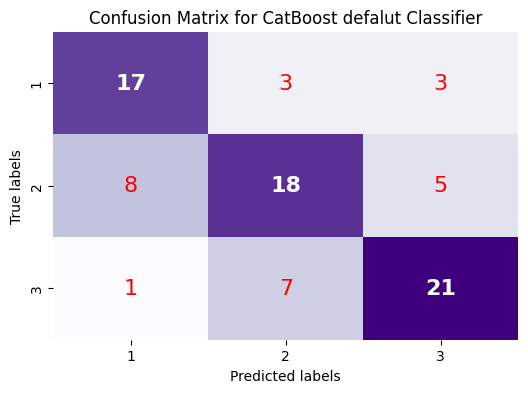

CatBoost default Classifier Report:
               precision    recall  f1-score   support

         1.0       0.65      0.74      0.69        23
         2.0       0.64      0.58      0.61        31
         3.0       0.72      0.72      0.72        29

    accuracy                           0.67        83
   macro avg       0.67      0.68      0.68        83
weighted avg       0.67      0.67      0.67        83



In [ ]:
#---Default model----
CB_model_def = CatBoostClassifier(random_state=42)
CB_model_def.fit(X_train, y_train)

# Cat Boost default hyperparameters
print("\nCatBoost default hyperparameters:")
print(CB_model_def.get_params())

y_pred_CB_def = CB_model_def.predict(X_test)

# Evaluation
print_confusion_matrix(y_test, y_pred_CB_def, "CatBoost defalut")
# print("Accuracy Score:", round(accuracy_score(y_test, y_pred_CB_def), 2))
print("CatBoost default Classifier Report:\n", classification_report(y_test, y_pred_CB_def))

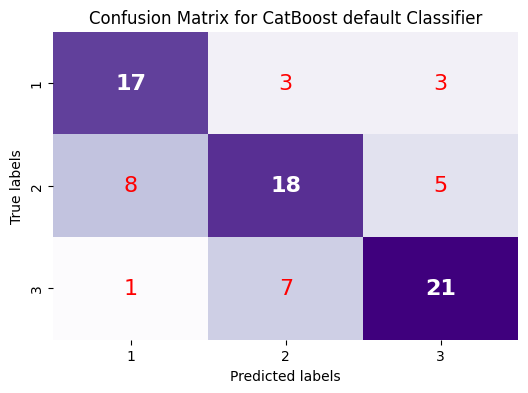

CatBoost default Classifier Report:
               precision    recall  f1-score   support

         1.0       0.65      0.74      0.69        23
         2.0       0.64      0.58      0.61        31
         3.0       0.72      0.72      0.72        29

    accuracy                           0.67        83
   macro avg       0.67      0.68      0.68        83
weighted avg       0.67      0.67      0.67        83



In [ ]:
# Evaluation
print_confusion_matrix(y_test, y_pred_CB_def.astype(float).astype(int).ravel(), "CatBoost default") # Change here: convert to float then to int and flatten
# print("Accuracy Score:", round(accuracy_score(y_test, y_pred_CB_def), 2))
print("CatBoost default Classifier Report:\n", classification_report(y_test, y_pred_CB_def))

In [ ]:
# Label encode the target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Define the Optuna objective function
def objective(trial):
    # Define the hyperparameters to tune
    params = {
        #"iterations": trial.suggest_int("iterations", 100, 500),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS","No"]),
        "depth": trial.suggest_int("depth", 1, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 0.1, 10),
        #"bagging_temperature": trial.suggest_float("bagging_temperature", 0, 10),
        "grow_policy": trial.suggest_categorical("grow_policy", ["SymmetricTree", "Depthwise", "Lossguide"]),
        "random_strength": trial.suggest_float("random_strength", 0, 10),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 10)
    }

    # Initialize the CatBoostClassifier
    model = CatBoostClassifier(
        eval_metric='TotalF1',
        verbose=0,
        random_seed=42,
        **params
    )

    # Use StratifiedKFold for cross-validation
    kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    f1_scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring="f1_macro")

    return f1_scores.mean()

# Run the Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=400)

# Get the best parameters
best_params = study.best_params
print("Best Parameters:", best_params)

# Train the model using the best parameters
best_model = CatBoostClassifier(
    eval_metric='TotalF1',
    verbose=0,
    random_seed=42,
    **best_params
)
best_model.fit(X_train, y_train_encoded)

# Predict on the test set
y_pred_CatBoost = best_model.predict(X_test)


[I 2025-02-24 16:22:17,309] A new study created in memory with name: no-name-f20ffb92-6313-4ec5-a20a-3611603b8b9f
[I 2025-02-24 16:22:21,885] Trial 0 finished with value: 0.6700832818014962 and parameters: {'bootstrap_type': 'Bernoulli', 'depth': 3, 'learning_rate': 0.020470419754224103, 'l2_leaf_reg': 5.526659943416967, 'grow_policy': 'Depthwise', 'random_strength': 5.090451813711111, 'min_data_in_leaf': 1}. Best is trial 0 with value: 0.6700832818014962.
[I 2025-02-24 16:22:25,181] Trial 1 finished with value: 0.6322572243986168 and parameters: {'bootstrap_type': 'Bayesian', 'depth': 4, 'learning_rate': 0.2651824926714773, 'l2_leaf_reg': 1.5878695167453012, 'grow_policy': 'Lossguide', 'random_strength': 3.3223686473505385, 'min_data_in_leaf': 9}. Best is trial 0 with value: 0.6700832818014962.
[I 2025-02-24 16:22:34,002] Trial 2 finished with value: 0.648013663012389 and parameters: {'bootstrap_type': 'Bayesian', 'depth': 5, 'learning_rate': 0.28940810487597773, 'l2_leaf_reg': 5.1271

Best Parameters: {'bootstrap_type': 'Bayesian', 'depth': 2, 'learning_rate': 0.04467100348279045, 'l2_leaf_reg': 9.349118588077772, 'grow_policy': 'Depthwise', 'random_strength': 7.812434995228157, 'min_data_in_leaf': 10}


In [ ]:
best_parameters = {'bootstrap_type': 'Bayesian',
                  'depth': 2,
                  'learning_rate': 0.04467100348279045,
                  'l2_leaf_reg': 9.349118588077772,
                  'grow_policy': 'Depthwise',
                  'random_strength': 7.812434995228157,
                  'min_data_in_leaf': 10}

SyntaxError: invalid syntax (<ipython-input-86-2aeccd88ab04>, line 1)

In [ ]:
# Label encode the target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

Accuracy Score:
 0.6746987951807228
CatBoost tuned Classifier Report:
               precision    recall  f1-score   support

           0       0.71      0.74      0.72        23
           1       0.59      0.61      0.60        31
           2       0.74      0.69      0.71        29

    accuracy                           0.67        83
   macro avg       0.68      0.68      0.68        83
weighted avg       0.68      0.67      0.68        83



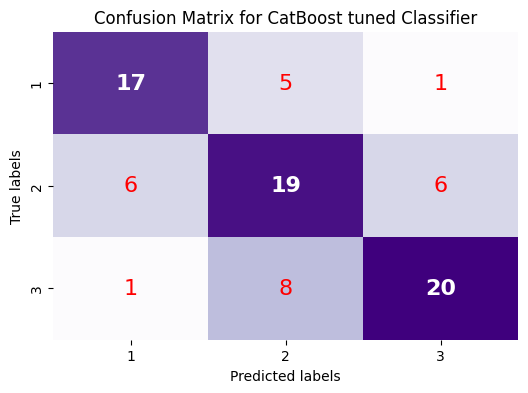

In [ ]:
# Evaluation metrics
print("Accuracy Score:\n", accuracy_score(y_test_encoded, y_pred_CatBoost))
print("CatBoost tuned Classifier Report:\n", classification_report(y_test_encoded, y_pred_CatBoost))

print_confusion_matrix(y_test_encoded+1, y_pred_CatBoost+1, "CatBoost tuned")

In [ ]:
def run_model_replications( ml_model, X_train, X_test, y_train, y_test, best_params, n_replications=10):
    """
    Run model multiple times and calculate statistics.

    Parameters:
    -----------
    X_train, X_test : array-like
        Training and test features
    y_train, y_test : array-like
        Training and test labels
    best_params : dict
        Best parameters from Optuna optimization
    n_replications : int
        Number of times to repeat the experiment

    Returns:
    --------
    dict
        Dictionary containing means and confidence intervals for each metric
    """
    # Initialize arrays to store metrics
    f1_scores = np.zeros(n_replications)
    accuracy_scores = np.zeros(n_replications)
    precision_scores = np.zeros(n_replications)
    recall_scores = np.zeros(n_replications)

    # Run the model n_replications times
    for i in range(n_replications):
        # Create and train model with best parameters
        model = ml_model(
            eval_metric='TotalF1',
            verbose=0,
            random_seed= 42 + i,  # Different seed for each replication
            **best_params
        )

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Calculate metrics
        f1_scores[i] = f1_score(y_test, y_pred, average='macro')
        accuracy_scores[i] = accuracy_score(y_test, y_pred)
        precision_scores[i] = precision_score(y_test, y_pred, average='macro')
        recall_scores[i] = recall_score(y_test, y_pred, average='macro')

    # Calculate statistics for each metric
    def calculate_stats(metric_scores):
        mean = np.mean(metric_scores)
        ci = stats.t.interval(
            confidence=0.95,
            df=len(metric_scores)-1,
            loc=np.mean(metric_scores),
            scale=stats.sem(metric_scores)
        )
        return {
            'mean': mean,
            'ci_lower': ci[0],
            'ci_upper': ci[1],
            'std': np.std(metric_scores),
            'raw_scores': metric_scores
        }

    results = {
        'f1_score': calculate_stats(f1_scores),
        'accuracy': calculate_stats(accuracy_scores),
        'precision': calculate_stats(precision_scores),
        'recall': calculate_stats(recall_scores)
    }

    return results

# Run the analysis
n_replications=10
results = run_model_replications(CatBoostClassifier,X_train, X_test, y_train_encoded, y_test_encoded, best_params)

# Print results in a formatted way
print("\nResults over", n_replications, "replications:\n")
for metric, stats in results.items():
    print(f"{metric.upper()}:")
    print(f"Mean: {stats['mean']:.4f}")
    print(f"95% CI: [{stats['ci_lower']:.4f}, {stats['ci_upper']:.4f}]")
    print(f"Standard Deviation: {stats['std']:.4f}")
    print()


Results over 10 replications:

F1_SCORE:
Mean: 0.6597
95% CI: [0.6556, 0.6638]
Standard Deviation: 0.0055

ACCURACY:
Mean: 0.6711
95% CI: [0.6669, 0.6752]
Standard Deviation: 0.0055

PRECISION:
Mean: 0.6718
95% CI: [0.6676, 0.6760]
Standard Deviation: 0.0055

RECALL:
Mean: 0.6595
95% CI: [0.6554, 0.6635]
Standard Deviation: 0.0054



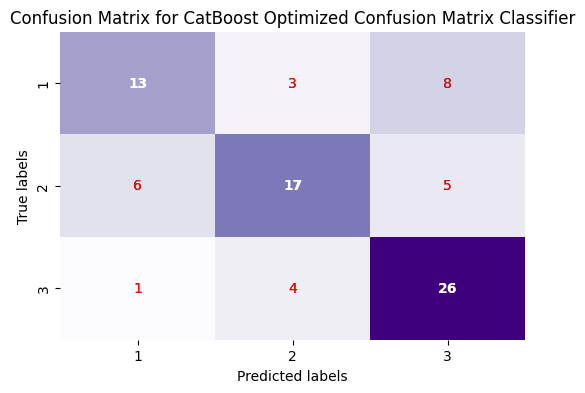

Accuracy Score:
 0.6746987951807228
CatBoost Optimized Classifier Report:
               precision    recall  f1-score   support

           0       0.65      0.54      0.59        24
           1       0.71      0.61      0.65        28
           2       0.67      0.84      0.74        31

    accuracy                           0.67        83
   macro avg       0.67      0.66      0.66        83
weighted avg       0.68      0.67      0.67        83



In [ ]:
print_confusion_matrix(y_test_encoded+1, y_pred_CatBoost+1, "CatBoost Optimized Confusion Matrix")

# Evaluation metrics
print("Accuracy Score:\n", accuracy_score(y_test_encoded, y_pred_CatBoost))
print("CatBoost Optimized Classifier Report:\n", classification_report(y_test_encoded, y_pred_CatBoost))


In [ ]:
optuna.visualization.plot_optimization_history(study).show()

# Plot parameter importance
optuna.visualization.plot_param_importances(study).show()

# ANN

In [23]:
# Liabaries
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import optuna
from sklearn.model_selection import StratifiedKFold, cross_val_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score
from sklearn.exceptions import ConvergenceWarning

In [24]:
# Suppress ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [25]:
# Normalize the data using Standard Scaler
standard_scaler = StandardScaler()
X_train_s = pd.DataFrame(standard_scaler.fit_transform(X_train), columns=X_train.columns)
X_test_s = pd.DataFrame(standard_scaler.transform(X_test), columns=X_test.columns)

# Normalize the data using MinMax Scaler
minmax_scaler = MinMaxScaler()
X_train_n = minmax_scaler.fit_transform(X_train)
X_test_n = minmax_scaler.transform(X_test)

**Deafult Models**

In [26]:
# Train basic ANN models with default parameters
model_MLP_Without_Scaling = MLPClassifier(random_state=42)
model_MLP_StandardScaler = MLPClassifier(random_state=42)
model_MLP_MinMaxScaler = MLPClassifier(random_state=42)

# Fit the models
model_MLP_Without_Scaling.fit(X_train, y_train)
model_MLP_StandardScaler.fit(X_train_s, y_train)
model_MLP_MinMaxScaler.fit(X_train_n, y_train)

MLPClassifier(random_state=42)

ANN default without scaling Classifier Report:
               precision    recall  f1-score   support

         1.0      0.406     0.565     0.473        23
         2.0      0.400     0.194     0.261        31
         3.0      0.528     0.655     0.585        29

    accuracy                          0.458        83
   macro avg      0.445     0.471     0.439        83
weighted avg      0.446     0.458     0.433        83



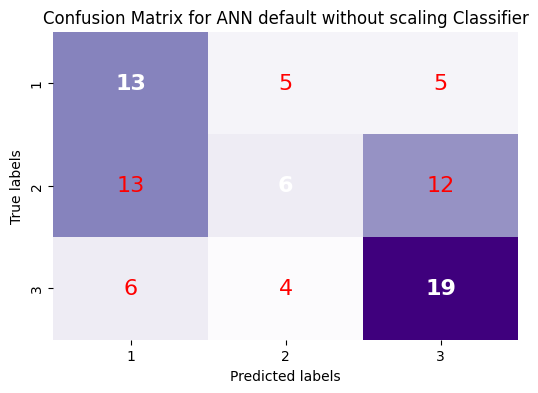

ANN default with StandardScaler Classifier Report:
               precision    recall  f1-score   support

         1.0      0.500     0.609     0.549        23
         2.0      0.517     0.484     0.500        31
         3.0      0.769     0.690     0.727        29

    accuracy                          0.590        83
   macro avg      0.595     0.594     0.592        83
weighted avg      0.601     0.590     0.593        83



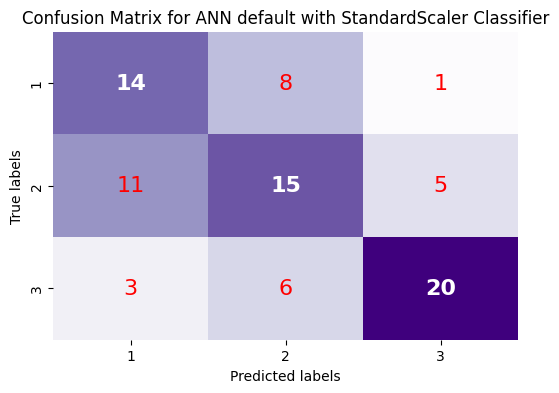

ANN default with MinMaxScaler Classifier Report:
               precision    recall  f1-score   support

         1.0      0.516     0.696     0.593        23
         2.0      0.458     0.355     0.400        31
         3.0      0.750     0.724     0.737        29

    accuracy                          0.578        83
   macro avg      0.575     0.592     0.576        83
weighted avg      0.576     0.578     0.571        83



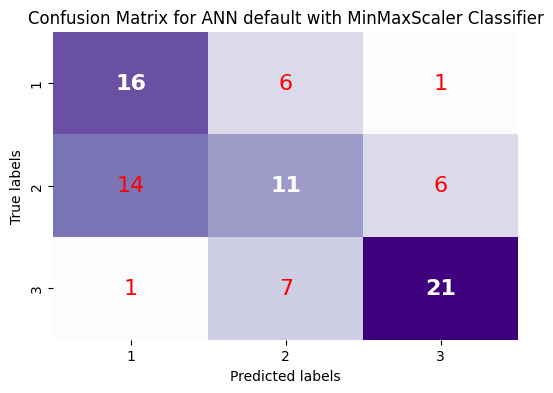

In [50]:
# Evaluate each default model
def evaluate_model(model, X_test, y_test, model_name):
    """
    Default Models Evaluation
    """
    y_pred = model.predict(X_test)
    print(f"{model_name} Classifier Report:\n", classification_report(y_test, y_pred, digits=3))

    # Use the existing confusion matrix function
    print_confusion_matrix(y_test, y_pred, model_name)

# Evaluate models
evaluate_model(model_MLP_Without_Scaling, X_test, y_test, "ANN default without scaling")
evaluate_model(model_MLP_StandardScaler, X_test_s, y_test, "ANN default with StandardScaler")
evaluate_model(model_MLP_MinMaxScaler, X_test_n, y_test, "ANN default with MinMaxScaler")

**Grid Search**

In [41]:
# Define parameter grid for Grid Search
param_grid = {
    'hidden_layer_sizes': [(64, 32), (128, 64), (64,), (128,)],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam', 'sgd', 'lbfgs'],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'max_iter': [200, 300, 400, 500]
}

**Perform GridSearchCV for each default model separately**

In [ ]:
# Grid search for model without scaling
grid_search_without_scaling = GridSearchCV(estimator=model_MLP_Without_Scaling, param_grid=param_grid, cv=3, scoring='f1_macro', verbose=2)
grid_search_without_scaling.fit(X_train, y_train)
tuned_model_without_scaling = grid_search_without_scaling.best_estimator_
print("Best parameters for model without Scaling:", grid_search_without_scaling.best_params_)

Fitting 3 folds for each of 1728 candidates, totalling 5184 fits
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(64, 32), learning_rate=constant, max_iter=200, solver=adam; total time=   0.3s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(64, 32), learning_rate=constant, max_iter=200, solver=adam; total time=   0.4s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(64, 32), learning_rate=constant, max_iter=200, solver=adam; total time=   0.5s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(64, 32), learning_rate=constant, max_iter=200, solver=sgd; total time=   0.2s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(64, 32), learning_rate=constant, max_iter=200, solver=sgd; total time=   0.2s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(64, 32), learning_rate=constant, max_iter=200, solver=sgd; total time=   0.1s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(64, 32), learning_rate=constant, max_iter=20

In [42]:
# Grid search for model with StandardScaler
grid_search_StandardScaler = GridSearchCV(estimator=model_MLP_StandardScaler, param_grid=param_grid, cv=3, scoring='f1_macro', verbose=2)
grid_search_StandardScaler.fit(X_train_s, y_train)
tuned_model_StandardScaler = grid_search_StandardScaler.best_estimator_
print("Best parameters for model with StandardScaler:", grid_search_StandardScaler.best_params_)

Streaming output truncated to the last 5000 lines.
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(128, 64), learning_rate=adaptive, max_iter=200, solver=sgd; total time=   1.0s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(128, 64), learning_rate=adaptive, max_iter=200, solver=lbfgs; total time=   1.3s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(128, 64), learning_rate=adaptive, max_iter=200, solver=lbfgs; total time=   1.4s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(128, 64), learning_rate=adaptive, max_iter=200, solver=lbfgs; total time=   0.4s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(128, 64), learning_rate=adaptive, max_iter=300, solver=adam; total time=   1.3s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(128, 64), learning_rate=adaptive, max_iter=300, solver=adam; total time=   2.7s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(128, 64), learning_rate=adaptive, max_iter=300,

In [43]:
# Grid search for model with MinMaxScaler
grid_search_MinMaxScaler = GridSearchCV(estimator=model_MLP_MinMaxScaler, param_grid=param_grid, cv=3, scoring='f1_macro', verbose=2)
grid_search_MinMaxScaler.fit(X_train_n, y_train)
tuned_model_MinMaxScaler = grid_search_MinMaxScaler.best_estimator_
print("Best parameters for model with MinMaxScaler:", grid_search_MinMaxScaler.best_params_)

Streaming output truncated to the last 5000 lines.
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(128, 64), learning_rate=adaptive, max_iter=200, solver=sgd; total time=   0.6s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(128, 64), learning_rate=adaptive, max_iter=200, solver=lbfgs; total time=   2.3s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(128, 64), learning_rate=adaptive, max_iter=200, solver=lbfgs; total time=   2.3s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(128, 64), learning_rate=adaptive, max_iter=200, solver=lbfgs; total time=   2.7s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(128, 64), learning_rate=adaptive, max_iter=300, solver=adam; total time=   1.6s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(128, 64), learning_rate=adaptive, max_iter=300, solver=adam; total time=   2.8s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(128, 64), learning_rate=adaptive, max_iter=300,

**Tuned Models**

In [37]:
# Tuned Model Without Scaling
tuned_model_without_scaling = MLPClassifier(
    hidden_layer_sizes=(128, 64),
    activation='logistic',
    solver='lbfgs',
    alpha=0.1,
    learning_rate='constant',
    max_iter=400,
    random_state=42
)

# Train the model
tuned_model_without_scaling.fit(X_train, y_train)

MLPClassifier(activation='logistic', alpha=0.1, hidden_layer_sizes=(128, 64),
              max_iter=400, random_state=42, solver='lbfgs')

In [39]:
# Tuned Model with StandardScaler
tuned_model_StandardScaler = MLPClassifier(
    hidden_layer_sizes=(64,),
    activation='logistic',
    solver='adam',
    alpha=0.01,
    learning_rate='constant',
    max_iter=200,
    random_state=4
)

# Train the model with the scaled data
tuned_model_StandardScaler.fit(X_train_s, y_train)

MLPClassifier(activation='logistic', alpha=0.01, hidden_layer_sizes=(64,),
              random_state=4)

In [44]:
# Tuned Model with MinMaxScaler
tuned_model_MinMaxScaler = MLPClassifier(
    hidden_layer_sizes=(128, 64),
    activation='logistic',
    solver='lbfgs',
    alpha=0.0001,
    learning_rate='constant',
    max_iter=300,
    random_state=42
)

# Train the model with the normalized data
tuned_model_MinMaxScaler.fit(X_train_n, y_train)

MLPClassifier(activation='logistic', hidden_layer_sizes=(128, 64), max_iter=300,
              random_state=42, solver='lbfgs')


--- Tuned Models Evaluation ---
ANN tuned Without Scaling Classifier Report:
               precision    recall  f1-score   support

         1.0      0.375     0.391     0.383        23
         2.0      0.423     0.355     0.386        31
         3.0      0.515     0.586     0.548        29

    accuracy                          0.446        83
   macro avg      0.438     0.444     0.439        83
weighted avg      0.442     0.446     0.442        83



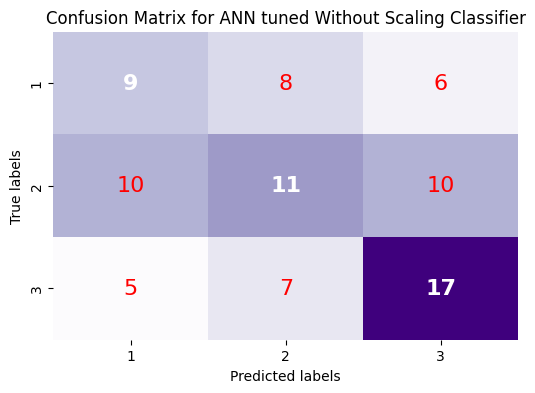

ANN tuned with StandardScaler Classifier Report:
               precision    recall  f1-score   support

         1.0      0.516     0.696     0.593        23
         2.0      0.500     0.419     0.456        31
         3.0      0.692     0.621     0.655        29

    accuracy                          0.566        83
   macro avg      0.569     0.579     0.568        83
weighted avg      0.572     0.566     0.563        83



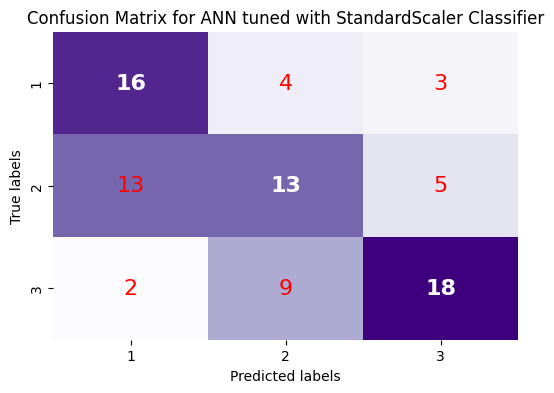

ANN tuned with MinMaxScaler Classifier Report:
               precision    recall  f1-score   support

         1.0      0.556     0.652     0.600        23
         2.0      0.500     0.548     0.523        31
         3.0      0.727     0.552     0.627        29

    accuracy                          0.578        83
   macro avg      0.594     0.584     0.584        83
weighted avg      0.595     0.578     0.581        83



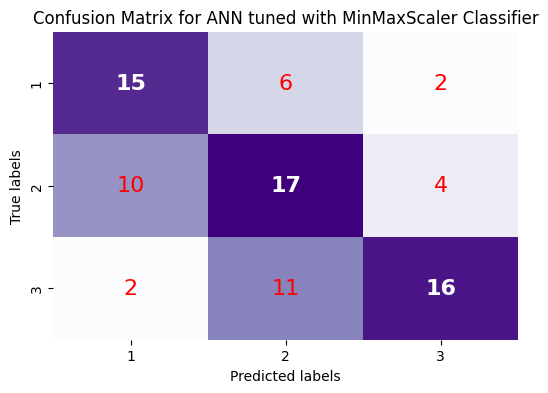

In [51]:
# Evaluate Tuned models
print("\n--- Tuned Models Evaluation ---")
# Model 1: Without Scaling
evaluate_model(tuned_model_without_scaling, X_test, y_test, "ANN tuned Without Scaling")
# Model 2: With StandardScaler
evaluate_model(tuned_model_StandardScaler, X_test_s, y_test, "ANN tuned with StandardScaler")
# Model 3: With MinMaxScaler
evaluate_model(tuned_model_MinMaxScaler, X_test_n, y_test, "ANN tuned with MinMaxScaler")

**Optuna**

In [30]:
def objective(trial):
    """
    Optuna optimization function for ANN hyperparameters - Tests a specific set of hyperparameters and returns F1-Score.
    """
    # Define hyperparameter search space
    hidden_layer_sizes = trial.suggest_categorical('hidden_layer_sizes', [(64,), (128,), (64, 32), (128, 64)])
    activation = trial.suggest_categorical('activation', ['relu', 'tanh', 'logistic'])
    solver = trial.suggest_categorical('solver', ['adam', 'sgd'])
    alpha = trial.suggest_loguniform('alpha', 1e-5, 1e-2)
    learning_rate = trial.suggest_categorical('learning_rate', ['constant', 'adaptive'])
    max_iter = trial.suggest_int('max_iter', 200, 500)

    # Initialize ANN model
    model = MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes,
        activation=activation,
        solver=solver,
        alpha=alpha,
        learning_rate=learning_rate,
        max_iter=max_iter,
        random_state=42
    )

    # Cross-validation
    kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    f1_scores = cross_val_score(model, X_train_n, y_train, cv=kfold, scoring="f1_macro")
    return f1_scores.mean()

# Perform the Optuna optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Print the best hyperparameters and train the final model
print("Best hyperparameters with Optuna optimizatio:", study.best_params)
model_optuna = MLPClassifier(**study.best_params, random_state=42)
model_optuna.fit(X_train_n, y_train)

[I 2025-02-25 11:32:04,957] A new study created in memory with name: no-name-7e6cad8e-9fa0-425e-9b0b-91a48dc8dcb7
[I 2025-02-25 11:32:05,113] Trial 0 finished with value: 0.19108793463784082 and parameters: {'hidden_layer_sizes': (64,), 'activation': 'logistic', 'solver': 'sgd', 'alpha': 2.925724663542302e-05, 'learning_rate': 'constant', 'max_iter': 206}. Best is trial 0 with value: 0.19108793463784082.
[I 2025-02-25 11:32:09,212] Trial 1 finished with value: 0.5850218854100003 and parameters: {'hidden_layer_sizes': (128,), 'activation': 'logistic', 'solver': 'adam', 'alpha': 0.007010807533101598, 'learning_rate': 'adaptive', 'max_iter': 414}. Best is trial 1 with value: 0.5850218854100003.
[I 2025-02-25 11:32:10,739] Trial 2 finished with value: 0.6203758353177916 and parameters: {'hidden_layer_sizes': (64,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.001938422599072218, 'learning_rate': 'constant', 'max_iter': 390}. Best is trial 2 with value: 0.6203758353177916.
[I 2025-02-

Best hyperparameters with Optuna optimization - Standartization: {'hidden_layer_sizes': (64,), 'activation': 'relu', 'solver': 'adam', 'alpha': 1.0362014217705608e-05, 'learning_rate': 'constant', 'max_iter': 387}


MLPClassifier(alpha=1.0362014217705608e-05, hidden_layer_sizes=(64,),
              max_iter=387, random_state=42)

In [34]:
# Update the ANN model according to the best parameters from Optuna
model_optuna_tuned = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation='relu',
    solver='adam',
    alpha=0.00044197541423821854,
    learning_rate='adaptive',
    max_iter=220,
    random_state=42
)

# Fit the model with the training data
model_optuna_tuned.fit(X_train_n, y_train)

MLPClassifier(alpha=0.00044197541423821854, hidden_layer_sizes=(64, 32),
              learning_rate='adaptive', max_iter=220, random_state=42)


--- Evaluation for Optuna-Tuned ANN ---
              precision    recall  f1-score   support

         1.0       0.48      0.57      0.52        23
         2.0       0.41      0.35      0.38        31
         3.0       0.72      0.72      0.72        29

    accuracy                           0.54        83
   macro avg       0.54      0.55      0.54        83
weighted avg       0.54      0.54      0.54        83



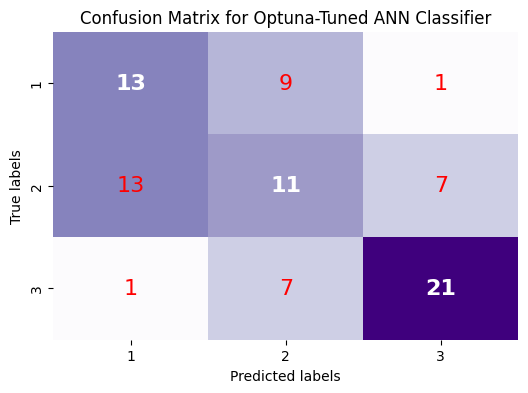

In [35]:
# Prediction and evaluation
#evaluate_model(model_optuna_tuned, X_test_n, y_test, "ANN tuned with StandardScaler")

print("\n--- Evaluation for Optuna-Tuned ANN ---")
y_pred_optuna = model_optuna_tuned.predict(X_test_n)
print(classification_report(y_test, y_pred_optuna))
print_confusion_matrix(y_test, y_pred_optuna, "Optuna-Tuned ANN")

[I 2025-02-25 11:46:13,402] A new study created in memory with name: no-name-d72d9008-2556-4f1b-8b1d-0647c6e05fa7
[I 2025-02-25 11:46:14,739] Trial 0 finished with value: 0.42697905724246676 and parameters: {'hidden_layer_sizes': (64,), 'activation': 'logistic', 'solver': 'sgd', 'alpha': 2.5567405781183558e-05, 'learning_rate': 'adaptive', 'max_iter': 407}. Best is trial 0 with value: 0.42697905724246676.
[I 2025-02-25 11:46:19,771] Trial 1 finished with value: 0.6174321431249589 and parameters: {'hidden_layer_sizes': (128, 64), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0007789173432802505, 'learning_rate': 'adaptive', 'max_iter': 454}. Best is trial 1 with value: 0.6174321431249589.
[I 2025-02-25 11:46:20,905] Trial 2 finished with value: 0.18248273369221435 and parameters: {'hidden_layer_sizes': (128, 64), 'activation': 'logistic', 'solver': 'sgd', 'alpha': 2.639011671089236e-05, 'learning_rate': 'adaptive', 'max_iter': 343}. Best is trial 1 with value: 0.6174321431249589.
[

Best hyperparameters with Optuna optimizatio: {'hidden_layer_sizes': (128, 64), 'activation': 'logistic', 'solver': 'adam', 'alpha': 0.0014262910099886808, 'learning_rate': 'adaptive', 'max_iter': 249}
              precision    recall  f1-score   support

         1.0       0.45      0.65      0.54        23
         2.0       0.43      0.10      0.16        31
         3.0       0.60      0.90      0.72        29

    accuracy                           0.53        83
   macro avg       0.50      0.55      0.47        83
weighted avg       0.50      0.53      0.46        83



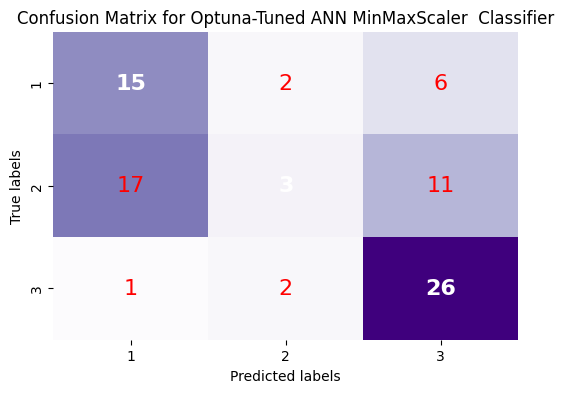

In [36]:
def objective(trial):
    """
    Optuna optimization function for ANN hyperparameters - Tests a specific set of hyperparameters and returns F1-Score.
    """
    # Define hyperparameter search space
    hidden_layer_sizes = trial.suggest_categorical('hidden_layer_sizes', [(64,), (128,), (64, 32), (128, 64)])
    activation = trial.suggest_categorical('activation', ['relu', 'tanh', 'logistic'])
    solver = trial.suggest_categorical('solver', ['adam', 'sgd'])
    alpha = trial.suggest_loguniform('alpha', 1e-5, 1e-2)
    learning_rate = trial.suggest_categorical('learning_rate', ['constant', 'adaptive'])
    max_iter = trial.suggest_int('max_iter', 200, 500)

    # Initialize ANN model
    model = MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes,
        activation=activation,
        solver=solver,
        alpha=alpha,
        learning_rate=learning_rate,
        max_iter=max_iter,
        random_state=42
    )

    # Cross-validation
    kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    f1_scores = cross_val_score(model, X_train_s, y_train, cv=kfold, scoring="f1_macro")
    return f1_scores.mean()

# Perform the Optuna optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Print the best hyperparameters and train the final model
print("Best hyperparameters with Optuna optimizatio:", study.best_params)
model_optuna = MLPClassifier(**study.best_params, random_state=42)
model_optuna.fit(X_train_s, y_train)

y_pred_optuna = model_optuna_tuned.predict(X_test_s)
print(classification_report(y_test, y_pred_optuna))
print_confusion_matrix(y_test, y_pred_optuna, "Optuna-Tuned ANN MinMaxScaler ")

In [ ]:
# Plot optimization history and parameter importance
optuna.visualization.plot_optimization_history(study).show()
optuna.visualization.plot_param_importances(study).show()

**CI**

In [52]:
# Tuned Model with MinMaxScaler
tuned_model_MinMaxScaler = MLPClassifier(
    hidden_layer_sizes=(128, 64),
    activation='logistic',
    solver='lbfgs',
    alpha=0.0001,
    learning_rate='constant',
    max_iter=300,
    random_state=42
)

# Train the model with the normalized data
tuned_model_MinMaxScaler.fit(X_train_n, y_train)
results = run_model_replications(tuned_model_MinMaxScaler, X_train_n, X_test_n, y_train, y_test, 10)
replications_print(results, 10)

TypeError: MLPClassifier(activation='logistic', hidden_layer_sizes=(128, 64), max_iter=300,
              random_state=42, solver='lbfgs') argument after ** must be a mapping, not int

# LightGBM

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000461 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 648
[LightGBM] [Info] Number of data points in the train set: 329, number of used features: 17
[LightGBM] [Info] Start training from score -1.296248
[LightGBM] [Info] Start training from score -0.975776
[LightGBM] [Info] Start training from score -1.051126
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

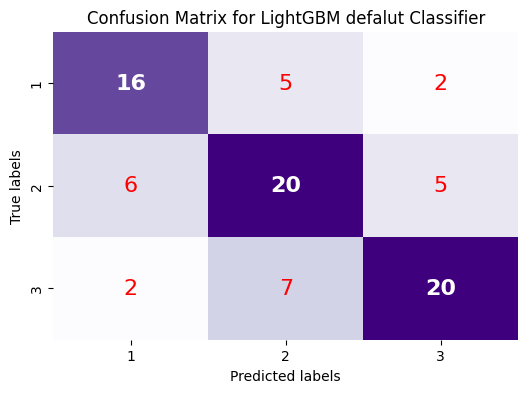

LGBM default Classifier Report:
               precision    recall  f1-score   support

         1.0       0.67      0.70      0.68        23
         2.0       0.62      0.65      0.63        31
         3.0       0.74      0.69      0.71        29

    accuracy                           0.67        83
   macro avg       0.68      0.68      0.68        83
weighted avg       0.68      0.67      0.68        83



In [ ]:
#---Default model----
LGBM_model_def = LGBMClassifier(random_state=42)
LGBM_model_def.fit(X_train, y_train)

# Cat Boost default hyperparameters
print("\n LGBM default hyperparameters:")
print(LGBM_model_def.get_params())

y_pred_LGBM_def = LGBM_model_def.predict(X_test)

# Evaluation
print_confusion_matrix(y_test, y_pred_LGBM_def, "LightGBM defalut")
print("LGBM default Classifier Report:\n", classification_report(y_test, y_pred_LGBM_def))

In [ ]:
# Label encode the target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

def objective(trial):
    # Parameters remain the same as previous version
    params = {
        'objective': 'multiclass',
        'metric': 'multi_logloss',
        'num_class': len(np.unique(y_train_encoded)),
        'boosting_type': 'gbdt',
        'verbosity': -1,

        'boosting_type ': trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'goss']),
        'num_leaves': trial.suggest_int('num_leaves', 2, 80),
        'max_depth': trial.suggest_int('max_depth', 2, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.3),
        #'reg_alpha': trial.suggest_float('reg_alpha', 1e-7, 1.0, log=True),
        #'reg_lambda': trial.suggest_float('reg_lambda', 1e-7, 1.0, log=True),
        #'min_gain_to_split': trial.suggest_float('min_gain_to_split', 1e-7, 0.1, log=True),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 3, 50),
        'n_estimators': trial.suggest_int('n_estimators', 10, 500)

    }

    scores = []
    feature_importance_list = []

    # Cross-validation setup
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Convert X_train to numpy array if it's a pandas DataFrame
    X_array = X_train.values if isinstance(X_train, pd.DataFrame) else X_train
    y_array = y_train_encoded

    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_array, y_array)):
        # Use iloc for pandas DataFrame or normal indexing for numpy array
        if isinstance(X_train, pd.DataFrame):
            X_fold_train = X_train.iloc[train_idx]
            X_fold_val = X_train.iloc[val_idx]
        else:
            X_fold_train = X_array[train_idx]
            X_fold_val = X_array[val_idx]

        y_fold_train = y_array[train_idx]
        y_fold_val = y_array[val_idx]

        model = LGBMClassifier(
            random_state=42,
            **params
        )

        model.fit(
            X_fold_train,
            y_fold_train,
            eval_set=[(X_fold_val, y_fold_val)],
            eval_metric='multi_logloss'
        )

        y_pred = model.predict(X_fold_val)
        fold_score = f1_score(y_fold_val, y_pred, average='macro')
        scores.append(fold_score)

        # Handle feature importance for both DataFrame and numpy array cases
        if isinstance(X_train, pd.DataFrame):
            feature_names = X_train.columns
        else:
            feature_names = [f'feature_{i}' for i in range(X_array.shape[1])]



    mean_score = np.mean(scores)
    std_score = np.std(scores)

    return mean_score

# Create and run the study
study = optuna.create_study(
    direction="maximize",
    study_name="lightgbm_optimization"
)

study.optimize(objective, n_trials=350, show_progress_bar=True)

[I 2025-02-24 17:25:53,898] A new study created in memory with name: lightgbm_optimization


  0%|          | 0/350 [00:00<?, ?it/s]

[I 2025-02-24 17:25:54,031] Trial 0 finished with value: 0.6800425242917693 and parameters: {'boosting_type': 'goss', 'num_leaves': 51, 'max_depth': 10, 'learning_rate': 0.27951894310371994, 'subsample': 0.42239054442938007, 'min_child_samples': 42, 'n_estimators': 11}. Best is trial 0 with value: 0.6800425242917693.
[I 2025-02-24 17:25:54,394] Trial 1 finished with value: 0.6660171407308367 and parameters: {'boosting_type': 'goss', 'num_leaves': 29, 'max_depth': 6, 'learning_rate': 0.09855586989536137, 'subsample': 0.9183122755674383, 'min_child_samples': 21, 'n_estimators': 64}. Best is trial 0 with value: 0.6800425242917693.
[I 2025-02-24 17:25:55,836] Trial 2 finished with value: 0.6501069208483912 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 73, 'max_depth': 4, 'learning_rate': 0.20772342410648117, 'subsample': 0.6038518471946053, 'min_child_samples': 30, 'n_estimators': 308}. Best is trial 0 with value: 0.6800425242917693.
[I 2025-02-24 17:25:56,024] Trial 3 finished w

In [ ]:
# Get the best parameters
best_params = study.best_params
print("Best Parameters:", best_params)

# Train the model using the best parameters
best_model = LGBMClassifier(
    random_seed=42,
    eval_metric='multi_logloss',
    **best_params
)
best_model.fit(X_train, y_train_encoded)

# Predict on the test set
y_pred_LightGBM  = best_model.predict(X_test)

Best Parameters: {'boosting_type': 'goss', 'num_leaves': 4, 'max_depth': 2, 'learning_rate': 0.06411927346017633, 'subsample': 0.9152405457972909, 'min_child_samples': 29, 'n_estimators': 368}


In [ ]:
best_parameters = {'boosting_type': 'goss',
                   'num_leaves': 4,
                   'max_depth': 2,
                   'learning_rate': 0.06411927346017633,
                   'subsample': 0.9152405457972909,
                   'min_child_samples': 29,
                   'n_estimators': 368}

Accuracy Score:
 0.6746987951807228
LightGBM tuned Classifier Report:
               precision    recall  f1-score   support

           0       0.71      0.74      0.72        23
           1       0.61      0.61      0.61        31
           2       0.71      0.69      0.70        29

    accuracy                           0.67        83
   macro avg       0.68      0.68      0.68        83
weighted avg       0.67      0.67      0.67        83



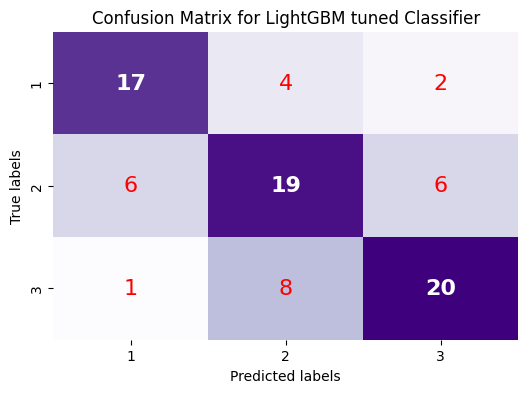

In [ ]:
# Label encode the target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Evaluation metrics
print("Accuracy Score:\n", accuracy_score(y_test_encoded, y_pred_LightGBM))
print("LightGBM tuned Classifier Report:\n", classification_report(y_test_encoded, y_pred_LightGBM))

print_confusion_matrix(y_test_encoded+1, y_pred_LightGBM+1, "LightGBM tuned")

In [ ]:
# Run the analysis
n_replications = 10
lgbm_model = LGBMClassifier(**best_params, random_state=42)
results = run_model_replications(lgbm_model, X_train, X_test, y_train_encoded, y_test_encoded, n_replications, model_type='lightgbm')

In [ ]:
# Print results in a formatted way
print("\nResults over", n_replications, "replications:\n")
for metric, stats in results.items():
    print(f"{metric.upper()}:")
    print(f"Mean: {stats['mean']:.4f}")
    print(f"95% CI: [{stats['ci_lower']:.4f}, {stats['ci_upper']:.4f}]")
    print(f"Standard Deviation: {stats['std']:.4f}")
    print()


Results over 10 replications:

F1_SCORE:
Mean: 0.6858
95% CI: [0.6720, 0.6995]
Standard Deviation: 0.0183

ACCURACY:
Mean: 0.6831
95% CI: [0.6690, 0.6972]
Standard Deviation: 0.0187

PRECISION:
Mean: 0.6844
95% CI: [0.6702, 0.6985]
Standard Deviation: 0.0188

RECALL:
Mean: 0.6886
95% CI: [0.6758, 0.7015]
Standard Deviation: 0.0170



In [ ]:
# Print results in a formatted way
print("\nResults over", n_replications, "replications:\n")
for metric, stats in results.items():
    print(f"{metric.upper()}:")
    print(f"Mean: {stats['mean']:.4f}")
    print(f"95% CI: [{stats['ci_lower']:.4f}, {stats['ci_upper']:.4f}]")
    print(f"Standard Deviation: {stats['std']:.4f}")
    print()


Results over 10 replications:

F1_SCORE:
Mean: 0.6610
95% CI: [0.6546, 0.6673]
Standard Deviation: 0.0084

ACCURACY:
Mean: 0.6699
95% CI: [0.6639, 0.6759]
Standard Deviation: 0.0080

PRECISION:
Mean: 0.6742
95% CI: [0.6682, 0.6803]
Standard Deviation: 0.0080

RECALL:
Mean: 0.6592
95% CI: [0.6530, 0.6654]
Standard Deviation: 0.0082



In [ ]:
optuna.visualization.plot_optimization_history(study).show()

# Plot parameter importance
optuna.visualization.plot_param_importances(study).show()

# KNN - 0.62 weighted f1

K-Nearest Neighbors (KNN) is a straightforward, non-parametric algorithm that classifies data points based on the majority class of their k closest neighbors. It is relevant for our dataset as it does not rely on assumptions about data distribution and works well with scaled features for distance-based classification. Key parameters include:
 , weights

*   n_neighbors - the number of neighbors considered for classification
*   weights - determines if all neighbors are equally important or weighted by distance
*   metric - the distance calculation method, such as Euclidean or Manhattan

**Default KNN Model**


KNN default hyperparameters:
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}


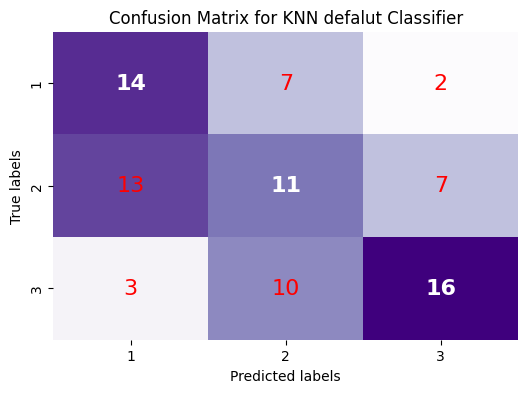

KNN default Classifier Report:
               precision    recall  f1-score   support

         1.0       0.47      0.61      0.53        23
         2.0       0.39      0.35      0.37        31
         3.0       0.64      0.55      0.59        29

    accuracy                           0.49        83
   macro avg       0.50      0.51      0.50        83
weighted avg       0.50      0.49      0.49        83



In [ ]:
#---Default model----
knn_model_def = KNeighborsClassifier() # No random state cause its a determinitic model

knn_model_def.fit(X_train_scaled, y_train)

# Random Forest default hyperparameters
print("\nKNN default hyperparameters:")
print(knn_model_def.get_params())

y_pred_KNN_def = knn_model_def.predict(X_test_scaled)

# Evaluation
print_confusion_matrix(y_test, y_pred_KNN_def, "KNN defalut")
print("KNN default Classifier Report:\n", classification_report(y_test, y_pred_KNN_def))

**Improved Model with Hyperparameter Tuning (with Standartization Scaling)**

[I 2025-02-24 17:41:09,141] A new study created in memory with name: no-name-534818bb-bb46-4741-b256-7ee8384b5192
[I 2025-02-24 17:41:09,194] Trial 0 finished with value: 0.546671522122003 and parameters: {'n_neighbors': 6, 'metric': 'minkowski', 'weights': 'uniform'}. Best is trial 0 with value: 0.546671522122003.
[I 2025-02-24 17:41:09,244] Trial 1 finished with value: 0.5336713308557465 and parameters: {'n_neighbors': 30, 'metric': 'minkowski', 'weights': 'uniform'}. Best is trial 0 with value: 0.546671522122003.
[I 2025-02-24 17:41:09,279] Trial 2 finished with value: 0.5785898766672446 and parameters: {'n_neighbors': 19, 'metric': 'minkowski', 'weights': 'distance'}. Best is trial 2 with value: 0.5785898766672446.
[I 2025-02-24 17:41:09,313] Trial 3 finished with value: 0.5750773164496504 and parameters: {'n_neighbors': 27, 'metric': 'minkowski', 'weights': 'distance'}. Best is trial 2 with value: 0.5785898766672446.
[I 2025-02-24 17:41:09,364] Trial 4 finished with value: 0.56716

Best hyperparameters: {'n_neighbors': 7, 'metric': 'manhattan', 'weights': 'uniform'}


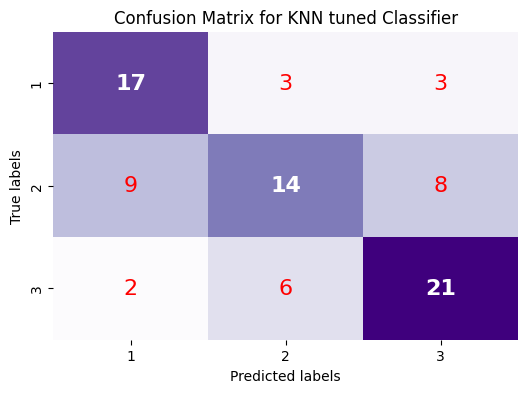

KNN tuned Classifier Report:
               precision    recall  f1-score   support

         1.0       0.61      0.74      0.67        23
         2.0       0.61      0.45      0.52        31
         3.0       0.66      0.72      0.69        29

    accuracy                           0.63        83
   macro avg       0.62      0.64      0.62        83
weighted avg       0.62      0.63      0.62        83

Improved F1 Score: 0.62


In [ ]:
# Objective function for Optuna
def objective(trial):
    # Hyperparameter search space
    n_neighbors = trial.suggest_int('n_neighbors', 1, 30)  # Range for k
    metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'minkowski']) # Distance calculation metric
    weights = trial.suggest_categorical('weights', ['uniform', 'distance']) # Neighbors influence

    # Initialize KNN model with hyperparameters
    knn = KNeighborsClassifier(
        n_neighbors=n_neighbors,
        metric=metric,
        weights=weights
    )

    # Cross-validation with StratifiedKFold
    kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    f1_scores = cross_val_score(knn, X_train_scaled, y_train, cv=kfold, scoring="f1_macro")

    return f1_scores.mean()

# Run Optuna optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Get the best hyperparameters
print("Best hyperparameters:", study.best_params)

# Train the model with best hyperparameters
best_knn_optuna = KNeighborsClassifier(**study.best_params)
best_knn_optuna.fit(X_train_scaled, y_train)

# Predict on test set
y_pred_KNN_tuned = best_knn_optuna.predict(X_test_scaled)

# Evaluate improved model performance
print_confusion_matrix(y_test, y_pred_KNN_tuned, "KNN tuned")
print("KNN tuned Classifier Report:\n", classification_report(y_test, y_pred_KNN_tuned))
improved_f1 = f1_score(y_test, y_pred_KNN_tuned, average='weighted')
print(f"Improved F1 Score: {round(improved_f1,2)}")

# Voting

Voting classifiers combine predictions from multiple models to enhance accuracy and robustness. By leveraging the strengths of tuned CatBoost and Random Forest models, this approach aims to improve performance in our multi-class classification task.

In [ ]:
%%capture
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.5.2

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000594 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 329, number of used features: 15
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score -1.296248
[LightGBM] [Info] Start training from score -0.975776
[LightGBM] [Info] Start training from score -1.051126
[LightGBM] [Warning] No further s

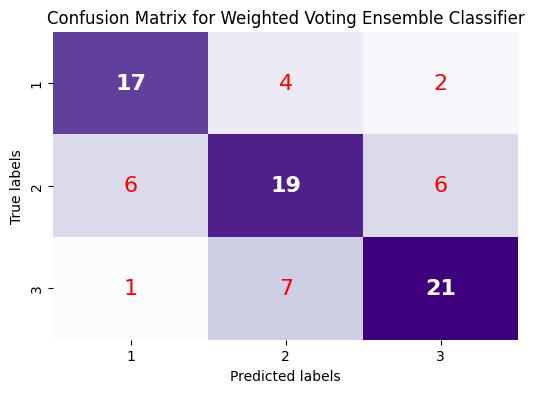

Voting Classifier Report:
               precision    recall  f1-score   support

         1.0      0.708     0.739     0.723        23
         2.0      0.633     0.613     0.623        31
         3.0      0.724     0.724     0.724        29

    accuracy                          0.687        83
   macro avg      0.689     0.692     0.690        83
weighted avg      0.686     0.687     0.686        83



In [53]:
from sklearn.ensemble import VotingClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

# Initialize all tuned models
tuned_rf = RandomForestClassifier(max_depth=31,
                                         max_features="log2",
                                         n_estimators=464,
                                         criterion='entropy',
                                         min_samples_split=10, random_state=42)

tuned_xgb = XGBClassifier(
    n_estimators=66,
    max_depth=10,
    learning_rate=0.007361899931803506,
    subsample=0.8496727956450908,
    colsample_bytree=0.6582704187129875,
    eval_metric="mlogloss",
    random_state=42
)

tuned_cat = CatBoostClassifier(
    bootstrap_type='Bayesian',
    depth=2,
    learning_rate=0.04467100348279045,
    l2_leaf_reg=9.349118588077772,
    grow_policy='Depthwise',
    random_strength=7.812434995228157,
    min_data_in_leaf=10,
    verbose=0,
    random_state=42
)

tuned_lgbm = LGBMClassifier(
    boosting_type='goss',
    num_leaves=4,
    max_depth=2,
    learning_rate=0.06411927346017633,
    subsample=0.9152405457972909,
    min_child_samples=29,
    n_estimators=368,
    random_state=42
)

f1_scores = [0.722, 0.711, 0.68, 0.67]
normalized_weights = [score/sum(f1_scores) for score in f1_scores]

# Create a weighted voting classifier
voting_classifier = VotingClassifier(
    estimators=[
        ('rf', tuned_rf),
        ('xgb', tuned_xgb),
        ('cat', tuned_cat),
        ('lgbm', tuned_lgbm)
    ],
    voting='soft',
    weights=normalized_weights
)

# Fit the voting classifier
voting_classifier.fit(X_train, y_train)

# Make predictions
y_pred_voting = voting_classifier.predict(X_test)

# Evaluate the ensemble model
print_confusion_matrix(y_test, y_pred_voting, "Weighted Voting Ensemble")
print("Voting Classifier Report:\n", classification_report(y_test, y_pred_voting, digits=3))

**CI**

In [54]:
results = run_model_replications(voting_classifier, X_train, X_test, y_train, y_test, 10)
replications_print(results, 10)

TypeError: VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(criterion='entropy',
                                                     max_depth=31,
                                                     max_features='log2',
                                                     min_samples_split=10,
                                                     n_estimators=464,
                                                     random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.6582704187129875,
                                            device=None,
                                            early_stopping_rounds=Non...
                             ('cat',
                              <catboost.core.CatBoostClassifier object at 0x7d311b59c850>),
                             ('lgbm',
                              LGBMClassifier(boosting_type='goss',
                                             learning_rate=0.06411927346017633,
                                             max_depth=2, min_child_samples=29,
                                             n_estimators=368, num_leaves=4,
                                             random_state=42,
                                             subsample=0.9152405457972909))],
                 voting='soft',
                 weights=[0.25943226733740565, 0.2554796981674452,
                          0.2443406395975566, 0.24074739489759256]) argument after ** must be a mapping, not int

# The chosen model

Stage-wise Performance Metrics for Random Forest

In [ ]:
rf_model_optuna = RandomForestClassifier(max_depth=31,
                                         max_features="log2",
                                         n_estimators=464,
                                         criterion='entropy',
                                         min_samples_split=10, random_state=42)
rf_model_optuna.fit(X_train, y_train)

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report

# Assuming you have your trained model and test data
y_pred = rf_model_optuna.predict(X_test)

# Get classification report with per-class metrics
report = classification_report(y_test, y_pred, output_dict=True)

# Convert unique labels in y_test to match dictionary keys
stage_labels = [str(float(label)) for label in np.unique(y_test)]  # Ensures correct lookup

# Extract precision, recall, and F1-score for each stage
precision = [report[label]['precision'] if label in report else 0 for label in stage_labels]
recall = [report[label]['recall'] if label in report else 0 for label in stage_labels]
f1_scores = [report[label]['f1-score'] if label in report else 0 for label in stage_labels]

# Define stage names for plotting
stages = [f"Stage {int(float(label))}" for label in stage_labels]

# Set up the bar chart
x = np.arange(len(stages))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))

# Plot the bars
precision_bars = ax.bar(x - width, precision, width, label='Precision', color='#9e5780')  # Dark mauve
recall_bars = ax.bar(x, recall, width, label='Recall', color='#c48ca3')  # Medium pink
f1_bars = ax.bar(x + width, f1_scores, width, label='F1-Score', color='#f2c6d8')  # Light pink

# Customize the chart
ax.set_ylim(0, 1.0)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Random Forest Performance Metrics by Cirrhosis Stage', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(stages, fontsize=11)
ax.legend(fontsize=11)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of each bar
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=10, fontweight='bold')

add_labels(precision_bars)
add_labels(recall_bars)
add_labels(f1_bars)

plt.tight_layout()
plt.savefig('rf_stage_performance.png', dpi=300)
plt.show()